## Setup

In [1]:
## Set up to import data from Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/ChuerYang_DataSci154/GridEmissions/'
data = file_path + '/data'
data_prep = file_path + '/data_prep'
raw = data_prep + '/raw'

# Install linearmodels package for panel data
!pip install linearmodels

## Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.panel import PanelOLS
from tabulate import tabulate

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00


## Import data

In [45]:
# Import data
# See problem set description for units on variables
df = pd.read_csv(file_path + "TXGridData.csv")

## Explore data

In [3]:
## Basic exploration
# Report the number of rows in the data
len(df)

35064

In [4]:
# Preview first 5 rows of data
df.head()

,date,year,month,day,hour,load,wind_gen,solar_gen,co2
0,1/1/2021,2021,1,1,0,44084,13924,0,19333
1,1/1/2021,2021,1,1,1,43445,14046,0,18727
2,1/1/2021,2021,1,1,2,43129,14473,0,18377
3,1/1/2021,2021,1,1,3,42988,14060,0,18444
4,1/1/2021,2021,1,1,4,43189,12590,0,19144


In [5]:
# Print variable names
print(df.columns)

Index(['date', 'year', 'month', 'day', 'hour', 'load', 'wind_gen', 'solar_gen',
       'co2'],
      dtype='object')


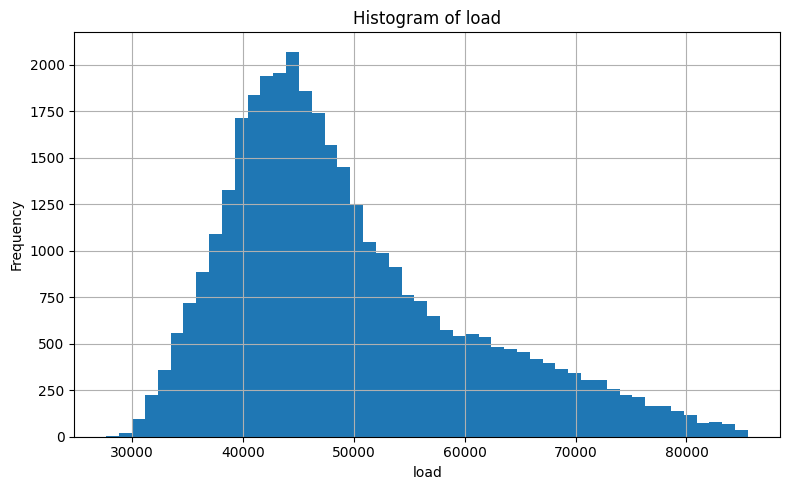

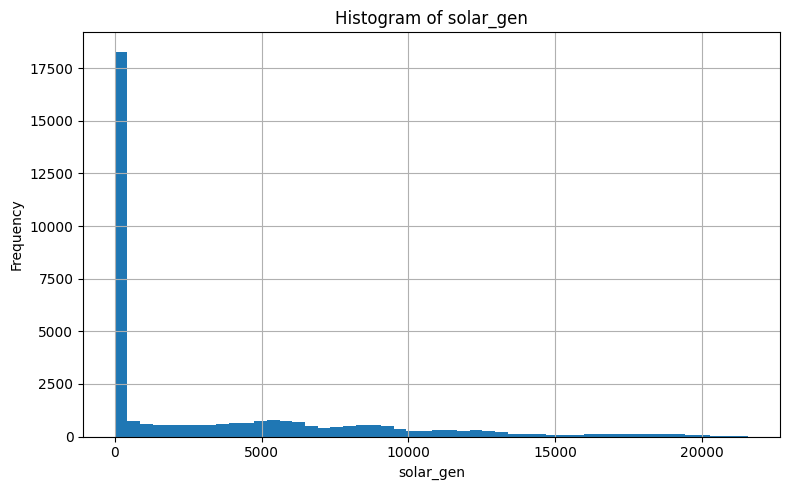

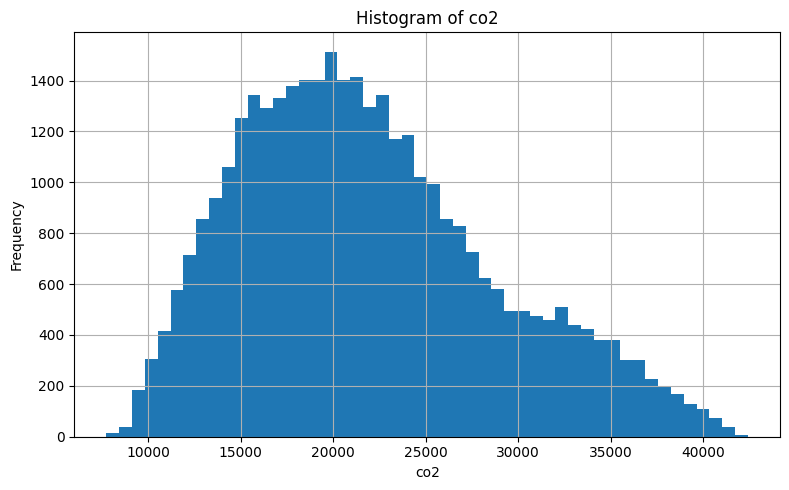

In [6]:
## Histograms of load, solar_gen, and co2
# Define columns to plot
cols = ['load', 'solar_gen', 'co2']

# Plot histograms
for col in cols:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col].dropna(), bins=50)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

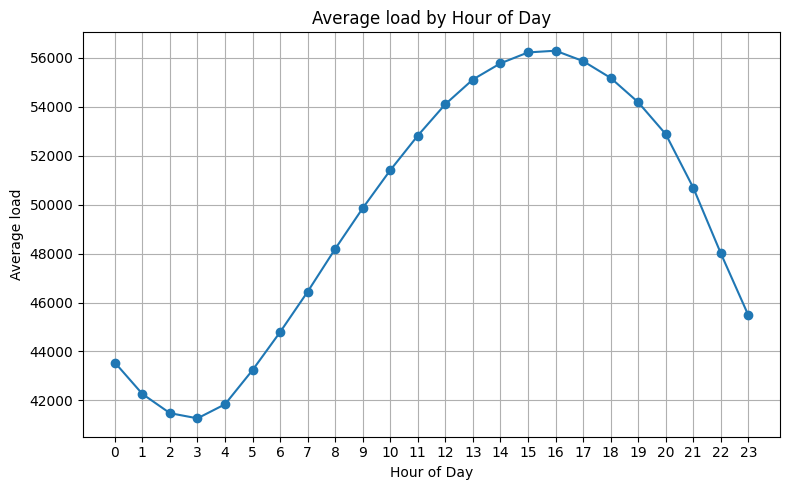

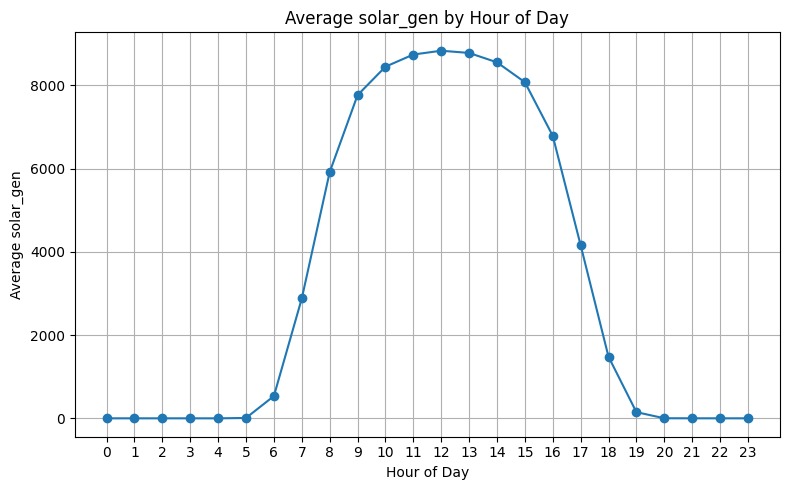

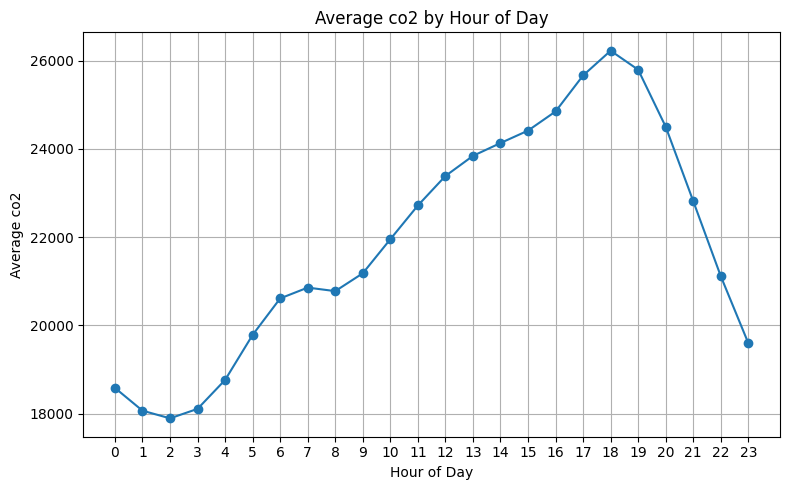

In [7]:
## Averages by hour of day
# Group by hour and compute means
hourly_means = df.groupby('hour')[cols].mean()

# Plot each variable
for col in cols:
    plt.figure(figsize=(8, 5))
    plt.plot(hourly_means.index, hourly_means[col], marker='o')
    plt.title(f"Average {col} by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel(f"Average {col}")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

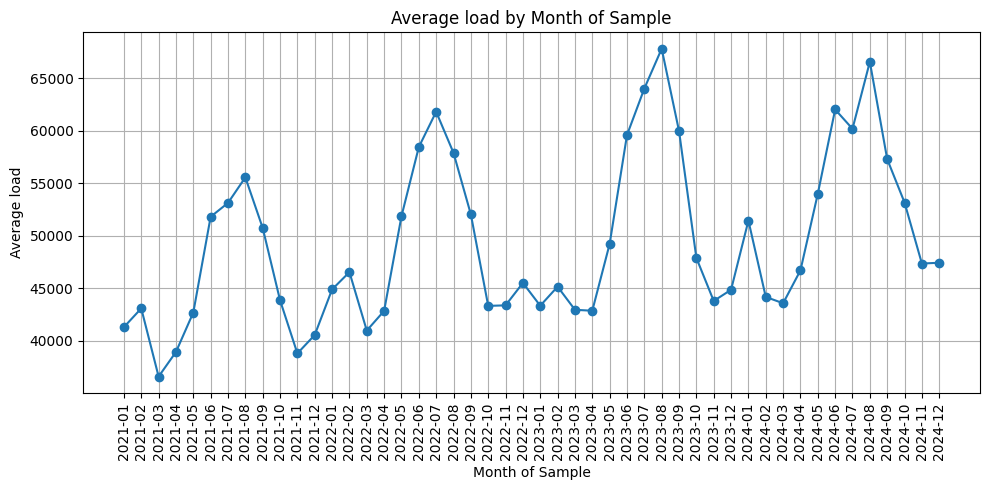

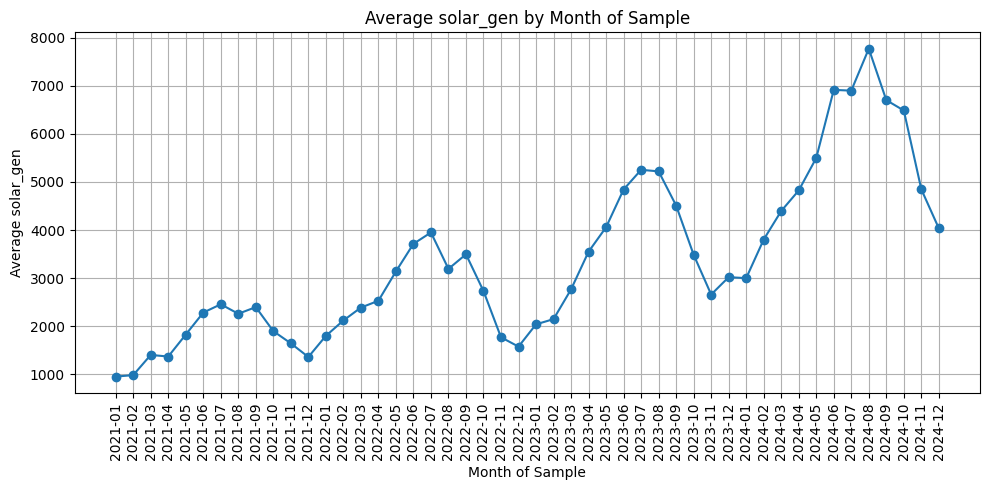

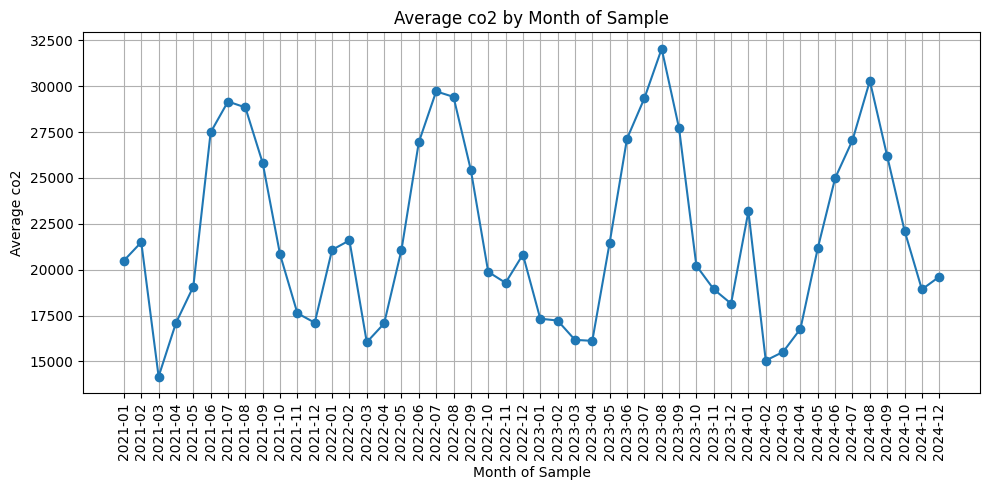

In [8]:
## Averages by month of sample
# Create a 'year_month' column for labeling (e.g., "2021-01")
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Group by both year and month
monthly_means = df.groupby(['year', 'month'])[cols].mean().reset_index()

# Sort and create a datetime-like label
monthly_means['year_month'] = monthly_means['year'].astype(str) + '-' + monthly_means['month'].astype(str).str.zfill(2)

# Plot
for col in cols:
    plt.figure(figsize=(10, 5))
    plt.plot(monthly_means['year_month'], monthly_means[col], marker='o')
    plt.title(f"Average {col} by Month of Sample")
    plt.xlabel("Month of Sample")
    plt.ylabel(f"Average {col}")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Regress solar generation on CO2 emissions

In [9]:
## Bivariate regression using AR(48) standard errors
X = sm.add_constant(df['solar_gen'])  # add intercept
y = df['co2']

# Run OLS regression
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 48})

# Print summary with AR(48) robust standard errors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    co2   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     375.6
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           3.11e-83
Time:                        21:49:28   Log-Likelihood:            -3.5872e+05
No. Observations:               35064   AIC:                         7.174e+05
Df Residuals:                   35062   BIC:                         7.175e+05
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.078e+04    165.483    125.550      0.0

<ipython-input-10-abc194f46e46>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby('solar_bin').agg({


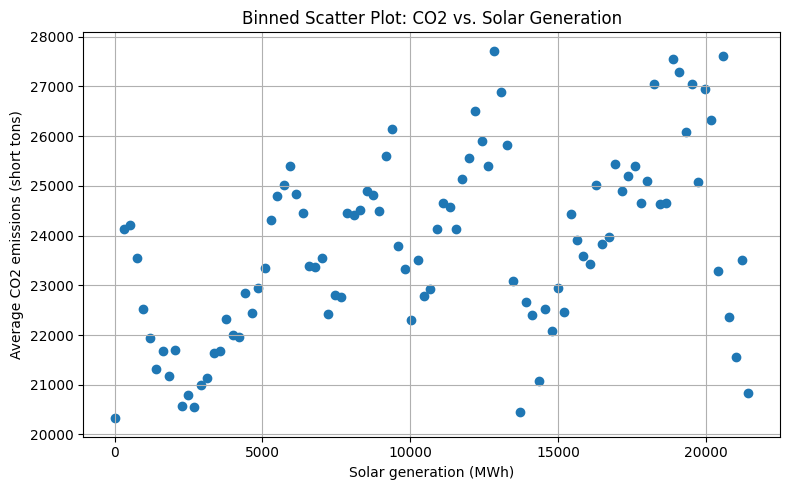

In [10]:
## Binned scatterplot
# Define number of bins
num_bins = 100

# Create bins for solar_gen
df['solar_bin'] = pd.cut(df['solar_gen'], bins=num_bins)

# Compute average solar_gen and co2 within each bin
binned = df.groupby('solar_bin').agg({
    'solar_gen': 'mean',
    'co2': 'mean'
}).dropna()

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(binned['solar_gen'], binned['co2'])
plt.xlabel('Solar generation (MWh)')
plt.ylabel('Average CO2 emissions (short tons)')
plt.title('Binned Scatter Plot: CO2 vs. Solar Generation')
plt.grid(True)
plt.tight_layout()
plt.show()

## Day-to-day variation

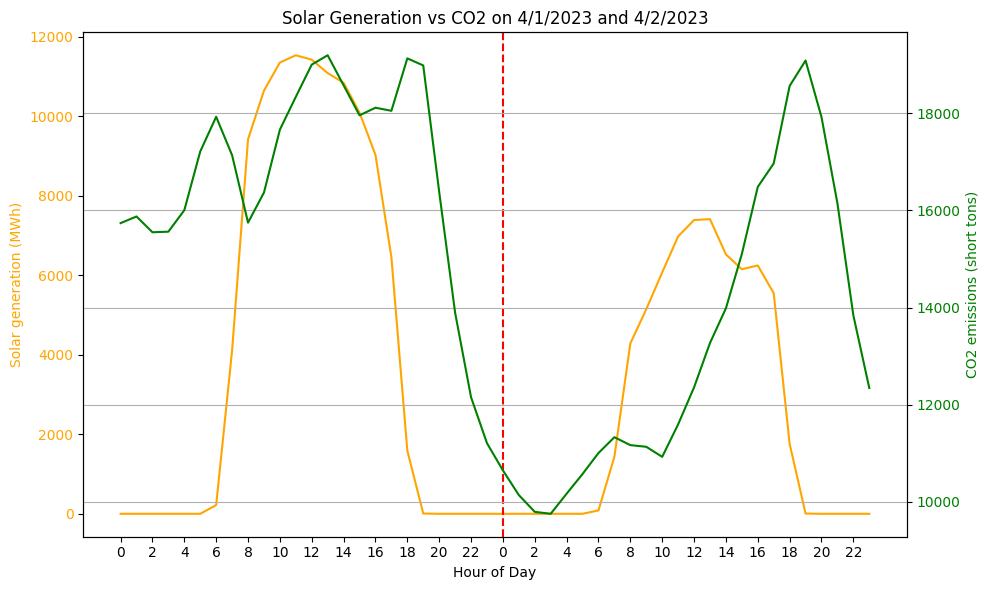

In [11]:
## Day to day variation demonstration

# Estable example days
example_day_1 = '4/1/2023'
example_day_2 = '4/2/2023'

# Filter data for the two days
mask = df['date'].isin([example_day_1, example_day_2])
df_48h = df[mask].copy()
df_48h = df_48h.sort_values(['date', 'hour']).reset_index(drop=True)

# Create hour-of-day labels for two days
hour_labels = list(range(24)) + list(range(24))
tick_locs = list(range(0, 48, 2))
tick_labels = [hour_labels[i] for i in tick_locs]

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_48h.index, df_48h['solar_gen'], color='orange', label='Solar Generation')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Solar generation (MWh)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Set x-axis labels to 0–23 twice
ax1.set_xticks(tick_locs)
ax1.set_xticklabels(tick_labels)

# Vertical line to split the two days
ax1.axvline(x=24, color='red', linestyle='--')

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(df_48h.index, df_48h['co2'], color='green', label='CO2')
ax2.set_ylabel('CO2 emissions (short tons)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title(f"Solar Generation vs CO2 on {example_day_1} and {example_day_2}")
plt.grid(True)
plt.tight_layout()
plt.show()

## Fixed effects regression

In [12]:
## Fixed effects regression

# Preprocessing
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['month_id'] = (df['date'].dt.year - df['date'].dt.year.min()) * 12 + df['date'].dt.month
df['month_hour'] = df['month_id'].astype(str) + "_" + df['hour'].astype(str)
df['time_id'] = df['day']  # arbitrary time ID

# Output storage
results = {}
model_names = [
    "Bivariate",
    "FE: Hr",
    "FE: Mnth",
]

# Loop over models
for i in range(3):
    if i in [0]:  # Use OLS with HAC
        controls = ['solar_gen', 'wind_gen']
        X = sm.add_constant(df[controls])
        y = df['co2']
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 48})
        results[i] = model
    else:  # Use PanelOLS with FE and AR(48) SEs
        fe_var = ['hour', 'month_id', 'month_hour'][i - 2]
        controls = ['solar_gen', 'wind_gen']
        df_panel = df.set_index([fe_var, 'time_id'])
        formula = f"co2 ~ {' + '.join(controls)}"
        model = PanelOLS.from_formula(formula, data=df_panel, drop_absorbed=True)
        n_time = df_panel.index.get_level_values(1).nunique()
        bw = min(48, n_time - 1)
        results[i] = model.fit(cov_type='kernel', kernel='bartlett', bandwidth=bw)

# Extract and transpose coefficients
output = {
    "solar_gen": [],
    "solar_gen_se": [],
    "wind_gen": [],
    "wind_gen_se": []
}

for i in range(3):
    model = results[i]

    # solar_gen
    coef_solar = model.params.get('solar_gen', float('nan'))
    se_solar = (model.bse if i < 1 else model.std_errors).get('solar_gen', float('nan'))

    # wind_gen
    coef_wind = model.params.get('wind_gen', float('nan'))
    se_wind = (model.bse if i < 1 else model.std_errors).get('wind_gen', float('nan'))

    output["solar_gen"].append(f"{coef_solar:.3f}")
    output["solar_gen_se"].append(f"({se_solar:.3f})")
    output["wind_gen"].append(f"{coef_wind:.3f}")
    output["wind_gen_se"].append(f"({se_wind:.3f})")

# Build transposed output table
df_output = pd.DataFrame(output, index=model_names).T
df_output.columns = model_names  # Make models the column headers

# Display
print(tabulate(df_output, headers="keys", tablefmt="fancy_grid", stralign="center"))

╒══════════════╤═════════════╤══════════╤════════════╕
│              │  Bivariate  │  FE: Hr  │  FE: Mnth  │
╞══════════════╪═════════════╪══════════╪════════════╡
│  solar_gen   │    0.121    │  1.416   │   1.416    │
├──────────────┼─────────────┼──────────┼────────────┤
│ solar_gen_se │   (0.017)   │ (0.014)  │  (0.014)   │
├──────────────┼─────────────┼──────────┼────────────┤
│   wind_gen   │   -0.531    │  1.049   │   1.049    │
├──────────────┼─────────────┼──────────┼────────────┤
│ wind_gen_se  │   (0.015)   │ (0.006)  │  (0.006)   │
╘══════════════╧═════════════╧══════════╧════════════╛


In [19]:
import pandas as pd
from linearmodels.panel import PanelOLS
import statsmodels.api as sm


# Parse datetime
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values('date')

# Create month_id: unique integer per month
df['month_id'] = (df['year'] - df['year'].min()) * 12 + df['month']

# Create month-hour fixed effect
df['month_hour'] = df['month_id'].astype(str) + "_" + df['hour'].astype(str)

# Create a unique time identifier for PanelOLS (e.g., hourly timestamp string)
df['time_id'] = df['date'].dt.strftime('%Y-%m-%d %H:%M')

# Set panel index: (entity, time)
df_panel = df.set_index(['month_hour', 'time_id'])

# Rename columns to remove dashes (Python syntax restriction)
df_panel = df_panel.rename(columns={
    'wind-gen': 'wind_gen',
    'solar-gen': 'solar_gen',
    'load': 'load',
    'co2': 'co2'
})

# Build formula: co2 ~ wind + solar + load, with month-hour FE
formula = 'co2 ~ wind_gen + solar_gen + load'

# Fit PanelOLS model
model = PanelOLS.from_formula(formula, data=df_panel, drop_absorbed=True)

# Bandwidth for HAC standard errors (e.g., 48 lags for 2 days of hourly data)
n_time = df_panel.index.get_level_values(1).nunique()
bw = min(48, n_time - 1)

# Fit with HAC (Bartlett kernel)
results = model.fit(cov_type='kernel', kernel='bartlett', bandwidth=bw)

# Print summary
print(results.summary)


ValueError: The index on the time dimension must be either numeric or date-like

In [23]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from tabulate import tabulate

# === Load data ===

# === Preprocessing ===
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['month_id'] = (df['date'].dt.year - df['date'].dt.year.min()) * 12 + df['date'].dt.month
df['month_hour'] = df['date'].dt.strftime('%Y-%m-%d %H')  # fine-grained hourly FE
df['time_id'] = df['date']  # arbitrary time ID (datetime is safe now)

# Clean numeric types
for col in ['solar_gen', 'wind_gen', 'load', 'co2']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna(subset=['solar_gen', 'wind_gen', 'load', 'co2'])

# === Model definitions ===
results = {}
model_names = [
    "Bivariate",
    "FE: Hour",
    "FE: Month",
    "FE: Month-Hour + Load"
]

fe_vars = [None, 'hour', 'month_id', 'month_hour']
controls_list = [
    ['solar_gen', 'wind_gen'],  # Bivariate
    ['solar_gen', 'wind_gen'],  # Hour FE
    ['solar_gen', 'wind_gen'],  # Month FE
    ['solar_gen', 'wind_gen', 'load']  # Month-Hour FE + load
]

for i in range(4):
    controls = controls_list[i]
    y = df['co2']

    if i == 0:
        # OLS with HAC
        X = sm.add_constant(df[controls])
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 48})
        results[i] = model
    else:
        fe_var = fe_vars[i]
        df_panel = df.set_index([fe_var, 'time_id'])
        formula = f"co2 ~ {' + '.join(controls)}"
        model = PanelOLS.from_formula(formula, data=df_panel, drop_absorbed=True)

        n_time = df_panel.index.get_level_values(1).nunique()
        bw = min(48, n_time - 1)

        results[i] = model.fit(cov_type='kernel', kernel='bartlett', bandwidth=bw)

# === Extract results ===
output = {
    "solar_gen": [],
    "solar_gen_se": [],
    "wind_gen": [],
    "wind_gen_se": []
}

for i in range(4):
    model = results[i]

    # Pull coefficients and SEs
    coef_solar = model.params.get('solar_gen', float('nan'))
    coef_wind = model.params.get('wind_gen', float('nan'))

    if i == 0:
        se_solar = model.bse.get('solar_gen', float('nan'))
        se_wind = model.bse.get('wind_gen', float('nan'))
    else:
        se_solar = model.std_errors.get('solar_gen', float('nan'))
        se_wind = model.std_errors.get('wind_gen', float('nan'))

    output["solar_gen"].append(f"{coef_solar:.3f}")
    output["solar_gen_se"].append(f"({se_solar:.3f})")
    output["wind_gen"].append(f"{coef_wind:.3f}")
    output["wind_gen_se"].append(f"({se_wind:.3f})")

# === Format and display table ===
df_output = pd.DataFrame(output, index=model_names).T
df_output.columns = model_names

print(tabulate(df_output, headers="keys", tablefmt="fancy_grid", stralign="center"))


╒══════════════╤═════════════╤════════════╤═════════════╤═════════════════════════╕
│              │  Bivariate  │  FE: Hour  │  FE: Month  │  FE: Month-Hour + Load  │
╞══════════════╪═════════════╪════════════╪═════════════╪═════════════════════════╡
│  solar_gen   │    0.121    │   1.416    │    1.416    │         -0.531          │
├──────────────┼─────────────┼────────────┼─────────────┼─────────────────────────┤
│ solar_gen_se │   (0.024)   │  (0.038)   │   (0.038)   │         (0.005)         │
├──────────────┼─────────────┼────────────┼─────────────┼─────────────────────────┤
│   wind_gen   │   -0.531    │   1.049    │    1.049    │         -0.523          │
├──────────────┼─────────────┼────────────┼─────────────┼─────────────────────────┤
│ wind_gen_se  │   (0.020)   │  (0.018)   │   (0.018)   │         (0.005)         │
╘══════════════╧═════════════╧════════════╧═════════════╧═════════════════════════╛


In [26]:
import pandas as pd
import statsmodels.api as sm
import patsy
from tabulate import tabulate

# Ensure datetime and types
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['load'] = pd.to_numeric(df['load'], errors='coerce')
df['co2'] = pd.to_numeric(df['co2'], errors='coerce')
df = df.dropna(subset=['load', 'co2'])

# Define regressions
formulas = {
    "Bivariate": "co2 ~ load",
    "FE: Hour": "co2 ~ load + C(hour)",
    "FE: Month": "co2 ~ load + C(month)",
    "FE: Month-Hour": "co2 ~ load + C(month):C(hour)"
}

results = {}

# Run models
for name, formula in formulas.items():
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 48})
    results[name] = model

output = {
    "load": [],
    "load_se": []
}

for name in formulas.keys():
    model = results[name]
    coef = model.params['load']
    se = model.bse['load']
    output["load"].append(f"{coef:.3f}")
    output["load_se"].append(f"({se:.3f})")

# Display
df_output = pd.DataFrame(output, index=formulas.keys()).T
print(tabulate(df_output, headers="keys", tablefmt="fancy_grid", stralign="center"))



╒═════════╤═════════════╤════════════╤═════════════╤══════════════════╕
│         │  Bivariate  │  FE: Hour  │  FE: Month  │  FE: Month-Hour  │
╞═════════╪═════════════╪════════════╪═════════════╪══════════════════╡
│  load   │    0.518    │   0.533    │    0.425    │      0.345       │
├─────────┼─────────────┼────────────┼─────────────┼──────────────────┤
│ load_se │   (0.007)   │  (0.010)   │   (0.009)   │     (0.020)      │
╘═════════╧═════════════╧════════════╧═════════════╧══════════════════╛


In [28]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

# Load the data

# Preprocessing
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['month_id'] = (df['date'].dt.year - df['date'].dt.year.min()) * 12 + df['date'].dt.month
df['month_hour'] = df['month_id'].astype(str) + "_" + df['hour'].astype(str)
df['time_id'] = df['day']  # time clustering at daily level
df = df.dropna(subset=['co2', 'solar_gen', 'wind_gen', 'load'])

# Set panel index
df_panel = df.set_index(['month_hour', 'time_id'])

# Define regression formula
formula = 'co2 ~ solar_gen + wind_gen + load'

# Fit model
model = PanelOLS.from_formula(formula, data=df_panel, drop_absorbed=True)

# Determine appropriate bandwidth for HAC
n_time = df_panel.index.get_level_values(1).nunique()
bw = min(48, n_time - 1)

# Fit with kernel HAC standard errors
res = model.fit(cov_type='kernel', kernel='bartlett', bandwidth=bw)

# Display results
print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                    co2   R-squared:                        0.9953
Estimator:                   PanelOLS   R-squared (Between):              0.9979
No. Observations:               35064   R-squared (Within):               0.8932
Date:                Tue, Jun 03 2025   R-squared (Overall):              0.9953
Time:                        04:16:29   Log-likelihood                -3.078e+05
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                   2.493e+06
Entities:                        1152   P-value                           0.0000
Avg Obs:                       30.438   Distribution:                 F(3,35061)
Min Obs:                       28.000                                           
Max Obs:                       32.000   F-statistic (robust):          8.782e+06
                            

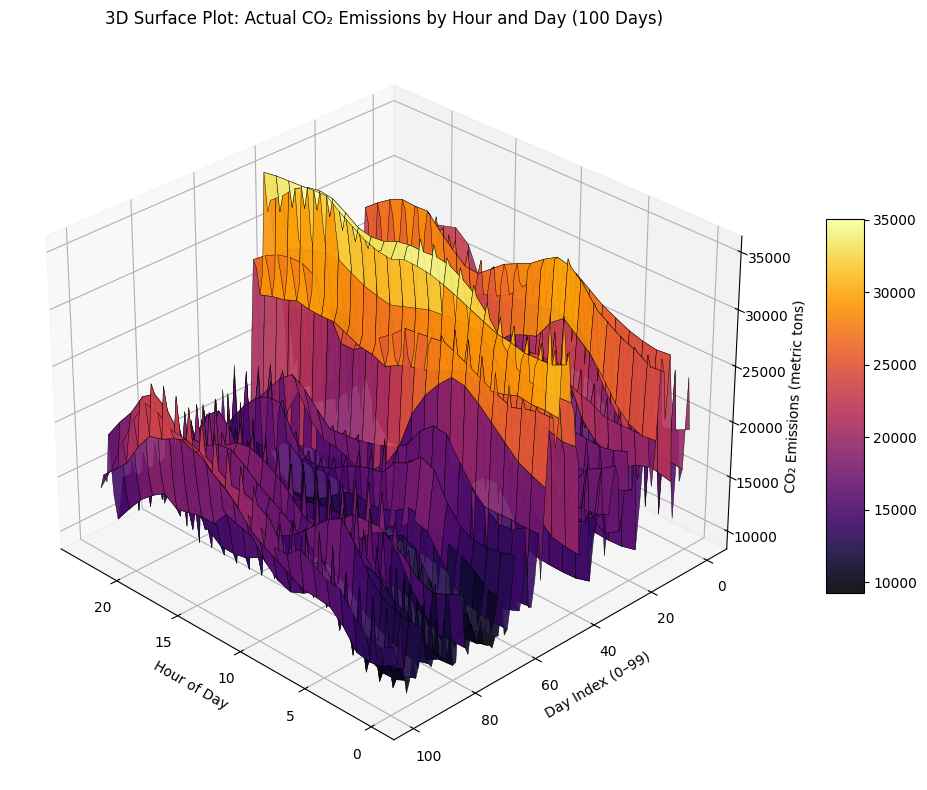

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Load and preprocess the data
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['day_str'] = df['date'].dt.strftime('%Y-%m-%d')
df = df[['day_str', 'hour', 'co2']]

# Select first 100 unique days
sample_days = df['day_str'].unique()[:100]
df_sample = df[df['day_str'].isin(sample_days)]

# Pivot: rows = hour, columns = day_str, values = actual CO₂ emissions
pivot = df_sample.pivot_table(index='hour', columns='day_str', values='co2')

# Create meshgrid for plotting
X_vals = pivot.index.values         # Hours (0–23)
Y_vals = np.arange(len(pivot.columns))  # Day indices (0–99)
X, Y = np.meshgrid(X_vals, Y_vals)
Z = pivot.values.T  # Shape: (days x hours)

# Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot using raw CO₂
surf = ax.plot_surface(X, Y, Z, cmap='inferno', edgecolor='k', linewidth=0.3, alpha=0.9)

# Labels
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day Index (0–99)")
ax.set_zlabel("CO₂ Emissions (metric tons)")
ax.set_title("3D Surface Plot: Actual CO₂ Emissions by Hour and Day (100 Days)")

# View settings
ax.view_init(elev=30, azim=135)

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


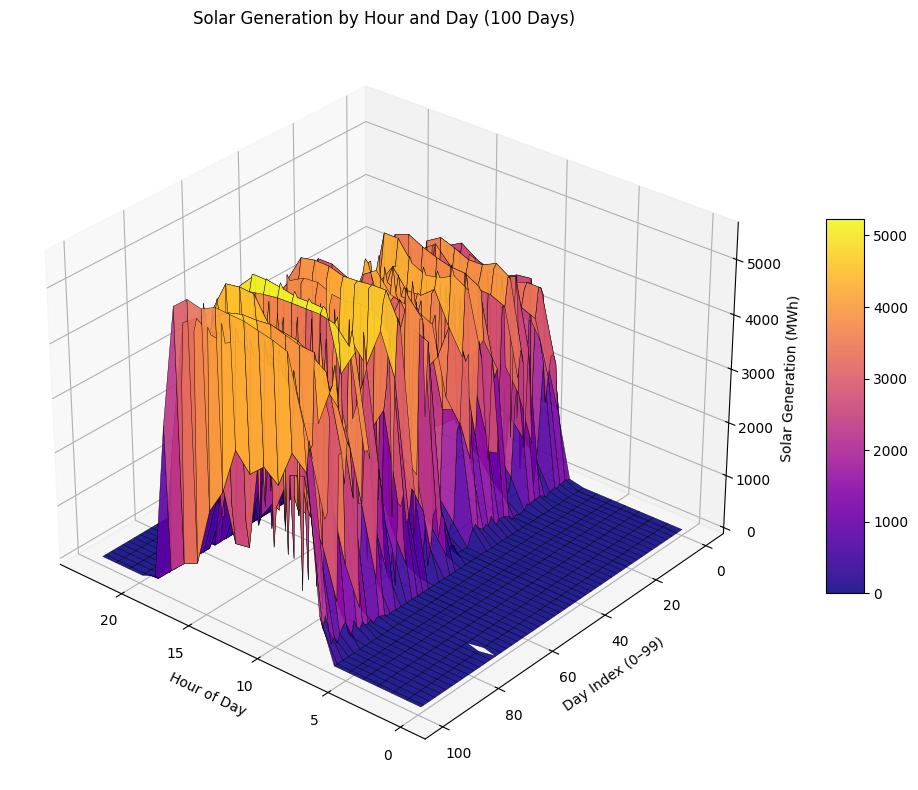

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Load and preprocess the data
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['day_str'] = df['date'].dt.strftime('%Y-%m-%d')

# Select first 100 unique days
sample_days = df['day_str'].unique()[:100]
df_sample = df[df['day_str'].isin(sample_days)]

# Pivot the data: rows = hour, columns = day_str, values = solar_gen
pivot = df_sample.pivot_table(index='hour', columns='day_str', values='solar_gen')

# Create meshgrid for plotting
X_vals = pivot.index.values  # 0-23 (hours)
Y_vals = np.arange(len(pivot.columns))  # 0 to 99 (100 days)
X, Y = np.meshgrid(X_vals, Y_vals)
Z = pivot.values.T  # Shape (100 days, 24 hours)

# Plotting
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='k', linewidth=0.3, alpha=0.9)

# Labels
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Day Index (0–99)")
ax.set_zlabel("Solar Generation (MWh)")
ax.set_title("Solar Generation by Hour and Day (100 Days)")

# View settings
ax.view_init(elev=30, azim=130)

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


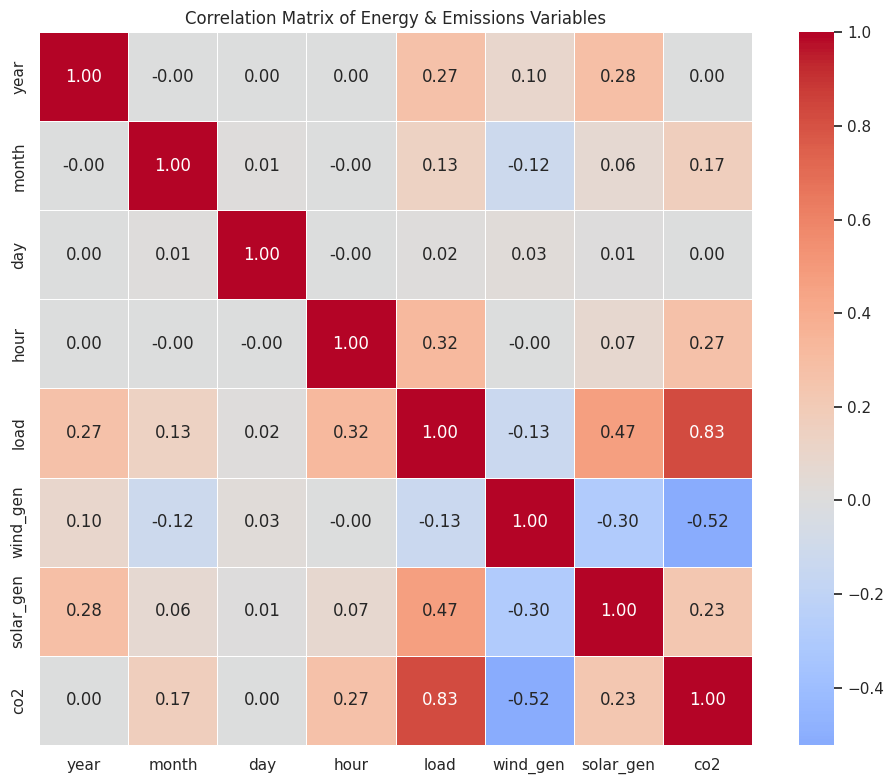

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Select relevant numeric variables
cols = ['year', 'month', 'day', 'hour', 'load', 'wind_gen', 'solar_gen', 'co2']
df_numeric = df[cols]

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Correlation Matrix of Energy & Emissions Variables")
plt.tight_layout()
plt.show()


In [49]:
df_sorted = df.sort_values(['year', 'month', 'day', 'hour'])
df_sorted['solar_diff'] = df_sorted['solar_gen'].diff()

# Optional: only keep diffs within the same day to avoid wrap-around noise
df_sorted['prev_hour'] = df_sorted['hour'].shift()
df_sorted['same_day'] = df_sorted['day'] == df_sorted['day'].shift()
df_hourly = df_sorted[df_sorted['same_day']]

# Compute standard deviation of hour-to-hour changes
print("Hourly variation (std of diffs):", df_hourly['solar_diff'].std())


Hourly variation (std of diffs): 1695.5493959975151


In [51]:
avg_solar = df['solar_gen'].mean()
print(f"Average solar generation: {avg_solar:.2f} MWh")


Average solar generation: 3379.66 MWh
